In [546]:
from Dataset.mnist import MNISTDataset

In [547]:
from lightning import Trainer
from torch.utils.data import DataLoader
from Model.mlp import MLP

In [548]:
import numpy as np

In [549]:
from torch.utils.data import Subset, DataLoader, ConcatDataset

In [ ]:
dataset = MNISTDataset()

train_indices = np.arange(len(dataset.train_set))
data_size=2500
num_client=10
train_subsets_indices = [train_indices[i * data_size:(i + 1) * data_size] for i in range(num_client)]
train_subsets = [Subset(dataset.train_set, indices) for indices in train_subsets_indices]
 
for i in range(1):   
    train_loader = DataLoader(train_subsets[i], batch_size=128, shuffle=True, num_workers=0)
    model = MLP()
    local_trainer = Trainer(max_epochs=10, accelerator="gpu", devices=1, logger=False,
                                                            # callbacks = [MyCustomCheckpoint(save_dir=f"{model_directory}/Local_models/Round_{r}",
                                                            # idx=client.idx, rou=r, logger=model_logger)],
                                                            enable_checkpointing=False, enable_model_summary=False, enable_progress_bar=True)
                                            
    local_trainer.fit(model, train_loader)                                       
                                                                    

In [ ]:
from Dataset.svhn import SVHNdataset
from Model.svhnresnet18 import SVHNResNet18
dataset = SVHNdataset()

train_indices = np.arange(len(dataset.train_set))
data_size=2500
num_client=10
train_subsets_indices = [train_indices[i * data_size:(i + 1) * data_size] for i in range(num_client)]
train_subsets = [Subset(dataset.train_set, indices) for indices in train_subsets_indices]
 
for i in range(1):   
    train_loader = DataLoader(train_subsets[i], batch_size=128, shuffle=True, num_workers=0)
    model = SVHNResNet18()
    local_trainer = Trainer(max_epochs=10, accelerator="gpu", devices=1, logger=False,
                                                            # callbacks = [MyCustomCheckpoint(save_dir=f"{model_directory}/Local_models/Round_{r}",
                                                            # idx=client.idx, rou=r, logger=model_logger)],
                                                            enable_checkpointing=False, enable_model_summary=False, enable_progress_bar=True)
                                            
    local_trainer.fit(model, train_loader)    
test_indices = np.arange(len(dataset.test_set))
data_size=2500
num_client=10
test_subsets_indices = [test_indices[i * data_size:(i + 1) * data_size] for i in range(num_client)]
test_subsets = [Subset(dataset.test_set, indices) for indices in test_subsets_indices]
test_loader = DataLoader(test_subsets[0], batch_size=128, shuffle=True, num_workers=0)
local_trainer.test(model, test_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 模型定义
class GAE(nn.Module):
    def __init__(self, num_nodes, hidden_dim, emb_dim):
        super(GAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_nodes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim)
        )

    def forward(self, S):
        Z = self.encoder(S)  # [N, emb_dim]
        adj_pred = torch.sigmoid(torch.matmul(Z, Z.t()))  # [N, N]
        return adj_pred

# # 示例使用
# num_nodes = 100  # 假设100个节点
# hidden_dim = 64
# emb_dim = 32

# model = GAE(num_nodes, hidden_dim, emb_dim)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# # 假设S为你的相似度矩阵，torch.Tensor类型
# S = torch.randn(num_nodes, num_nodes)  # 实际换为你的相似度矩阵

# # 训练过程
# epochs = 200
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     adj_pred = model(S)
#     loss = F.mse_loss(adj_pred, S)
#     loss.backward()
#     optimizer.step()

#     if epoch % 20 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# # 推断边
# model.eval()
# with torch.no_grad():
#     adj_pred = model(S)

# # 预测边的信息(阈值化处理)
# threshold = 0.5
# predicted_edges = (adj_pred > threshold).float()

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
import pandas as pd

In [2]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels * 4, out_channels, heads=1, concat=False)
        self.norm = torch.nn.LayerNorm(out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = self.norm(x)
        return x

class Decoder(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, Z):
        N = Z.shape[0]
        pairs = torch.stack(torch.meshgrid(torch.arange(N), torch.arange(N)), dim=-1).reshape(-1, 2)
        zi = Z[pairs[:, 0]]
        zj = Z[pairs[:, 1]]
        z_concat = torch.cat([zi, zj], dim=1)
        pred = self.mlp(z_concat).view(N, N)
        return pred

class GAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        # adj_pred = torch.sigmoid(torch.matmul(z, z.T)) 
        adj_pred = self.decoder(z)
        return adj_pred
    
    

In [3]:
from skimage.filters import threshold_otsu

def threshold_by_otsu(adj_pred):
    if hasattr(adj_pred, 'detach'):
        adj_np = adj_pred.detach().cpu().numpy().flatten()
    else:
        adj_np = adj_pred.flatten()
    threshold = threshold_otsu(adj_np)

    edge_matrix = (adj_pred >= threshold).float()
    return edge_matrix, threshold

In [4]:
from kneed import KneeLocator

def threshold_by_knee(adj_pred, pd=7):
    scores = np.sort(adj_pred.flatten())[::-1]
    kneedle = KneeLocator(range(len(scores)), scores, curve='convex', direction='decreasing', interp_method="polynomial", polynomial_degree=pd)
    threshold = scores[kneedle.knee]
    return (adj_pred >= threshold).float(), threshold

In [5]:
def sigmoid_stretch(x, alpha=10):
    return 1 / (1 + np.exp(-alpha * (x - 0.5)))

In [6]:
import numpy as np

# Reconvert matrix using numpy
def contrastive_normalization_np(sim, eta=3):
    sim = np.copy(sim)
    col_min = sim.min(axis=0, keepdims=True)

    # Sort each column and get the second largest value
    sorted_cols = np.sort(sim, axis=0)
    second_max = sorted_cols[-2, :].reshape(1, -1)
    
    # col_max = sim.max(axis=0, keepdims=True)

    eps = 1e-8
    normalized = (sim - col_min) / (second_max - col_min + eps)

    normalized = np.clip(normalized, 0, 1)
    normalized = (normalized + normalized.T) / 2
    normalized = np.power(normalized, eta)
    
    return normalized

# Redefine transformation functions using NumPy
def amplify_similarity_np(sim, gamma=5):
    return (1.0 - sim) ** gamma 

In [7]:
def build_sparse_edge(sim_matrix, k=3):
    """
    从相似度矩阵构建稀疏 edge_index 和 edge_weight，用于 GAT 等模型。
    """
    N = sim_matrix.shape[0]
    edge_index = []
    edge_weight = []
    for i in range(N):
        topk = torch.topk(sim_matrix[i], k + 1).indices  # +1 是包含自己
        for j in topk:
            if i != j:
                edge_index.append([i, j])
                edge_weight.append(sim_matrix[i][j])  # 记录边权重
    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, E]
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)  # shape [E]
    return edge_index, edge_weight

In [8]:
def build_sparse_edge_otsu(sim_matrix):
    """
    使用 Otsu 自动阈值从相似度矩阵构建稀疏 edge_index 和 edge_weight。
    输入：
        sim_matrix: torch.Tensor, shape [N, N]，应为对称相似度矩阵
    输出：
        edge_index: torch.LongTensor, shape [2, E]
        edge_weight: torch.FloatTensor, shape [E]
    """
    N = sim_matrix.shape[0]

    # 转为 numpy 计算 otsu 阈值
    sim_np = sim_matrix.cpu().numpy()
    threshold = threshold_otsu(sim_np.flatten())

    edge_index = []
    edge_weight = []

    for i in range(N):
        for j in range(N):
            if i != j and sim_np[i, j] >= threshold:
            # if sim_np[i, j] >= threshold:
                edge_index.append([i, j])
                edge_weight.append(sim_np[i, j].item())

    edge_index = torch.tensor(edge_index, dtype=torch.long).T  # shape [2, E]
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)  # shape [E]

    return edge_index, edge_weight, threshold

In [9]:
df_path = "J:\TIA\TIA\saved_results\Cosine_Similarity\Extra_cases_30\Mnist_mlp_star_1_0.1_42_3_30\Round_39.xlsx"
df = pd.read_excel(df_path)

In [10]:
sim_matrix_np = df.values.astype(np.float32)

In [11]:
sim_matrix_np = df.values.astype(np.float32)
sim_matrix_np = contrastive_normalization_np(sim_matrix_np,eta=2)
# sim_matrix_np = np.exp(sim_matrix_np)
# sim_matrix_np

In [12]:
sim_matrix = torch.tensor(sim_matrix_np, dtype=torch.float32)

In [13]:
x = sim_matrix
edge_index, edge_weight = build_sparse_edge(sim_matrix)
# edge_index, edge_weight, sparse_th = build_sparse_edge_otsu(sim_matrix)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

In [14]:
encoder = GATEncoder(in_channels=x.size(1), hidden_channels=32, out_channels=16)
decoder = Decoder(input_dim=16)
model = GAE(encoder, decoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    adj_pred = model(data.x, data.edge_index)
    loss = F.mse_loss(adj_pred, sim_matrix)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

j:\TIA\.venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0 | Loss: 0.1113
Epoch 20 | Loss: 0.0414
Epoch 40 | Loss: 0.0351
Epoch 60 | Loss: 0.0338
Epoch 80 | Loss: 0.0330
Epoch 100 | Loss: 0.0318
Epoch 120 | Loss: 0.0314
Epoch 140 | Loss: 0.0291
Epoch 160 | Loss: 0.0262
Epoch 180 | Loss: 0.0239


In [16]:
model.eval()
with torch.no_grad():
    adj_pred = model(data.x, data.edge_index)
    # edge_matrix, threshold = threshold_by_knee(adj_pred)
    # adj_pred = soft_threshold(adj_pred, tau=0.7)
    edge_matrix, threshold = threshold_by_otsu(adj_pred)

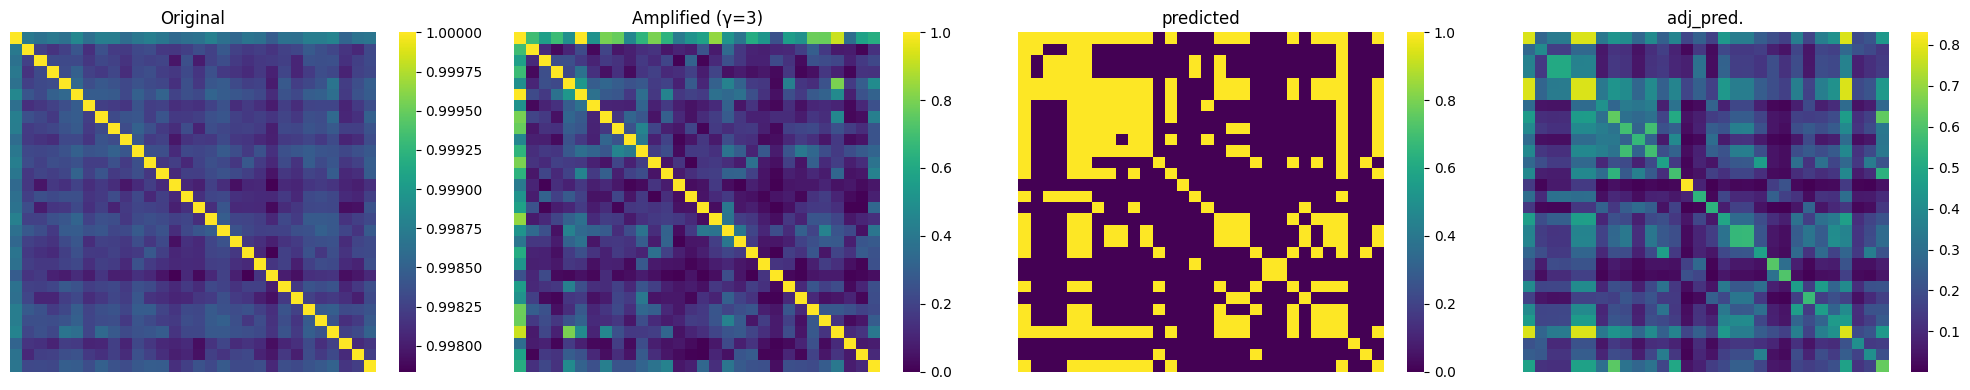

In [17]:
# Switch to using only NumPy for compatibility
import numpy as np

# Reconvert matrix using numpy
sim_matrix_np = df.values.astype(np.float32)


# Apply transformations
methods_np = {
    "Original": df.values,
    "Amplified (γ=3)": sim_matrix,
    "predicted": edge_matrix,
    "adj_pred.": adj_pred,
}

# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(methods_np), figsize=(20, 4))
for ax, (title, matrix) in zip(axes, methods_np.items()):
    sns.heatmap(matrix, ax=ax, cmap="viridis", cbar=True)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()
